In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import copy
import umap
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# Define the CNN model in PyTorch
class MyCNNModel(nn.Module):
    def __init__(self, no_classes):
        super(MyCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3)) # output shape: 
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3))
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, no_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def generate_model(output_dim=100):
    model = MyCNNModel(output_dim)
    return model.to(device)

In [4]:
def visualize_convolutions(layer, show = True, save = False, filename="conv_filter.png"):
    first_layer_weights = layer.weight.data.numpy()
    min_val = first_layer_weights.min(axis=(1, 2, 3), keepdims=True)
    max_val = first_layer_weights.max(axis=(1, 2, 3), keepdims=True)
    first_layer_weights = (first_layer_weights - min_val) / (max_val - min_val)

    grid_size = 8
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        if i < 64:
            filter = np.transpose(first_layer_weights[i], (1, 2, 0))
            ax.imshow(filter)
            ax.axis('off')
        else:
            ax.axis('off')
    if show:
        plt.show()
    if save:
        plt.savefig(filename)
    plt.close(fig)

In [6]:
models = []
num_models = 19
for i in range(1,num_models+1):
    model_state_dict = torch.load(f"models/model_0_{i}.pt", map_location=torch.device('cpu'))
    model = generate_model(10)
    model.load_state_dict(model_state_dict)
    models.append(model)

In [7]:
filters_layer_1 = []
filters_layer_2 = []
filters_layer_3 = []
for model in models:
    for i in range(model.conv1.weight.shape[0]):
        filters_layer_1.append(model.conv1.weight[i].detach().numpy())
    for i in range(model.conv2.weight.shape[0]):
        filters_layer_2.append(model.conv2.weight[i].detach().numpy())
    for i in range(model.conv3.weight.shape[0]):
        filters_layer_3.append(model.conv3.weight[i].detach().numpy())
filters_layer_1 = np.array(filters_layer_1)
filters_layer_2 = np.array(filters_layer_2)
filters_layer_3 = np.array(filters_layer_3)

In [8]:
filters_layer_1_flat = []
for i in range(filters_layer_1.shape[0]):
    filters_layer_1_flat.append(filters_layer_1[i].flatten())
filters_layer_1_flat = np.array(filters_layer_1_flat)

In [9]:
### Extract the three input channels first layer
filters_layer_1_ch1 = []
filters_layer_1_ch2 = []
filters_layer_1_ch3 = []
for i in range(filters_layer_1.shape[0]):
    filters_layer_1_ch1.append(filters_layer_1[i][0].flatten())
    filters_layer_1_ch2.append(filters_layer_1[i][1].flatten())
    filters_layer_1_ch3.append(filters_layer_1[i][2].flatten())
filters_layer_1_ch1 = np.array(filters_layer_1_ch1)
filters_layer_1_ch2 = np.array(filters_layer_1_ch2)
filters_layer_1_ch3 = np.array(filters_layer_1_ch3)

In [11]:
filters_layer_1_flat.shape

(1216, 27)

In [14]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(filters_layer_1_flat)

Text(0.5, 1.0, 'UMAP of first layer convolutional filters colored based on original Model')

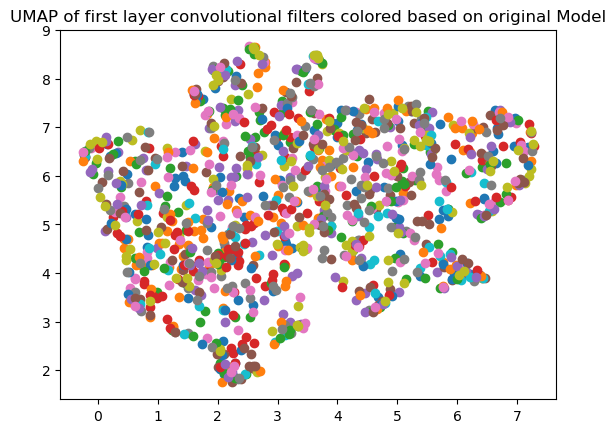

In [17]:
for i in range(num_models):
    plt.scatter(embedding[64*i:64*(i+1)-1, 0], embedding[64*i:64*(i+1)-1, 1], label=f"Model {i}")
plt.title("UMAP of first layer convolutional filters colored based on original Model")

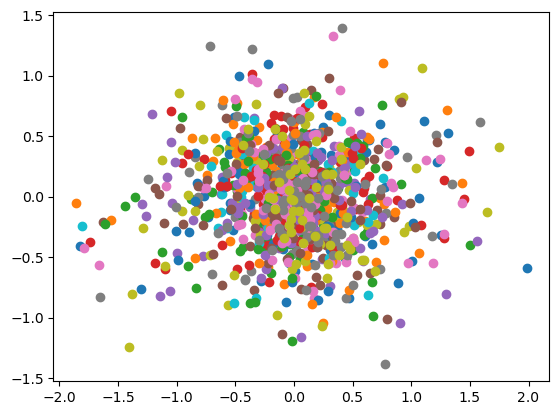

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
fil_trans_pca = pca.fit_transform(filters_layer_1_flat)
for i in range(num_models):
    plt.scatter(fil_trans_pca[64*i:64*(i+1)-1, 0], fil_trans_pca[64*i:64*(i+1)-1, 1], label=f"Model {i}")

### Comptute euclidean distance between all filters

In [19]:
euc_dist = []
for i in range(filters_layer_1.shape[0]):
    euc_dist.append([])
    for j in range(filters_layer_1.shape[0]):
        euc_dist[i].append(np.linalg.norm(filters_layer_1_flat[i]-filters_layer_1_flat[j]))

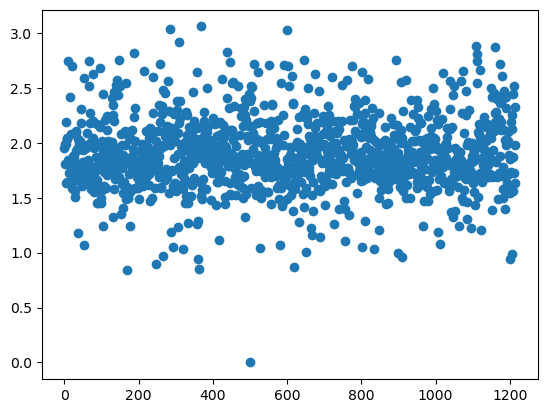

In [27]:
plt.scatter(np.linspace(0,len(euc_dist)-1,len(euc_dist)),np.array(euc_dist).T[500])

In [29]:
filters_layer_1.shape

(1216, 3, 3, 3)

In [32]:
mean_layer_1 = np.mean(filters_layer_1, axis=0)
std_layer_1 = np.std(filters_layer_1, axis=0)
std_layer_1

array([[[0.21049304, 0.21069312, 0.20576099],
        [0.21403821, 0.21973169, 0.21946467],
        [0.21785988, 0.24168865, 0.22601615]],

       [[0.2021638 , 0.22910851, 0.20548522],
        [0.21844414, 0.24061945, 0.22893271],
        [0.20944643, 0.23259915, 0.21602322]],

       [[0.20505005, 0.20416409, 0.20116094],
        [0.21071382, 0.20650727, 0.21801658],
        [0.21720514, 0.22338201, 0.23000187]]], dtype=float32)

In [67]:
means_l1 = np.mean(filters_layer_1, axis=(1,2,3))
std_l1 = np.std(filters_layer_1, axis=(1,2,3))

In [92]:
def mult(i,j, filters):
    return np.sum(filters[i]*filters[j])

def pearson_correlation(i,j, filters, means, stds):
    return np.sum((filters[i]-means[i])*(filters[j]-means[j]))/(27*stds[i]*stds[j])

In [93]:
pcs = []
for i in range(filters_layer_1.shape[0]):
    pcs.append([])
    for j in range(filters_layer_1.shape[0]):
        pcs[i].append(abs(pearson_correlation(i,j, filters_layer_1, means_l1, std_l1)))
pcs = np.array(pcs)

In [91]:
pearson_correlation(3,3, filters_layer_1, means_l1, std_l1)

26.999998

In [ ]:
pers

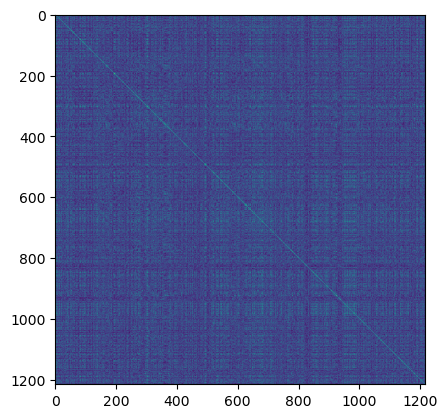

In [100]:
plt.imshow(pcs)

In [96]:
import pandas as pd
pd.DataFrame(pcs)

,0,1,2,3,4,5,6,7,8,9,...,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215
0,1.000000,0.148634,0.111489,0.450486,0.082851,0.128666,0.289837,0.393971,0.143249,0.008053,...,0.449439,0.332884,0.079181,0.104388,0.002622,0.515480,0.066308,0.127722,0.180518,0.395813
1,0.148634,1.000000,0.248735,0.175770,0.474336,0.109247,0.310799,0.197926,0.288843,0.377849,...,0.107394,0.276682,0.060640,0.003815,0.416358,0.094306,0.499257,0.228364,0.451697,0.002059
2,0.111489,0.248735,1.000000,0.108915,0.174064,0.004264,0.161745,0.089507,0.343445,0.455051,...,0.073553,0.108562,0.265045,0.292247,0.184911,0.053076,0.305779,0.399800,0.033011,0.157166
3,0.450486,0.175770,0.108915,1.000000,0.121695,0.551639,0.414996,0.292038,0.332089,0.326344,...,0.548386,0.560991,0.078751,0.080769,0.086689,0.570065,0.119032,0.060703,0.594270,0.254377
4,0.082851,0.474336,0.174064,0.121695,1.000000,0.265608,0.849776,0.614211,0.214452,0.026514,...,0.464152,0.201352,0.002125,0.248089,0.665265,0.188369,0.599180,0.188896,0.221210,0.299012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,0.515480,0.094306,0.053076,0.570065,0.188369,0.705749,0.465563,0.712471,0.212620,0.146190,...,0.722589,0.307611,0.043582,0.102840,0.022305,1.000000,0.044875,0.122025,0.438448,0.340948
1212,0.066308,0.499257,0.305779,0.119032,0.599180,0.169407,0.506727,0.424563,0.293861,0.298715,...,0.346374,0.257579,0.027602,0.250750,0.561100,0.044875,1.000000,0.071186,0.289257,0.078872
1213,0.127722,0.228364,0.399800,0.060703,0.188896,0.083289,0.101578,0.178450,0.540271,0.230854,...,0.025652,0.016382,0.081596,0.092447,0.047680,0.122025,0.071186,1.000000,0.070547,0.108642
1214,0.180518,0.451697,0.033011,0.594270,0.221210,0.385546,0.055182,0.091770,0.262144,0.485484,...,0.405654,0.815360,0.073862,0.176733,0.288444,0.438448,0.289257,0.070547,1.000000,0.199231


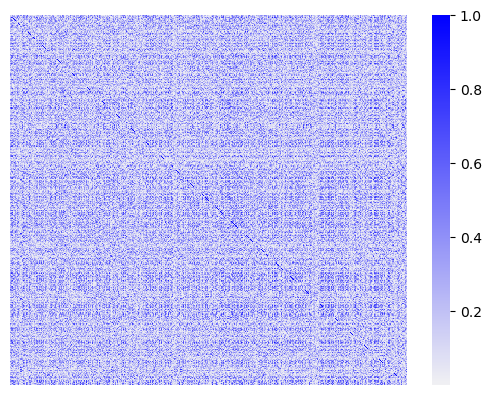

In [110]:
ax = sns.heatmap(pcs, linewidth=0.5,xticklabels=False, yticklabels=False,linecolor=None,cmap=sns.color_palette("light:b", as_cmap=True))
plt.show()